<a href="https://colab.research.google.com/github/ryanmdpeters21/Data-Analysis/blob/main/Football_Analytics_with_Python_chap6_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# We want to analyze the likelihood of certain prop bets occuring.
# We can look at a Poisson distribution for this.
# We can count the frequencies for certain outcomes: 0, 1, 2 TD passes, etc.
# we can start by installing and importing our packages.

In [2]:
!pip install nfl_data_py
!pip install numpy
!pip install nfl_data_py
!pip install statsmodels
!pip install matplotlib
!pip install seaborn

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=67d92369ea3176a9a68e7ffaefd7b1a04b71b5403dd79bf23117ce1d843b649f
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [3]:
!pip install scipy

In [4]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

In [5]:
# We can load in our data.
seasons = range(2016, 2022+1)
pbp_py = \
  nfl.import_pbp_data(seasons)

pbp_py_pass = \
  pbp_py.\
    query('passer_id.notnull()')\
    .reset_index()

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [6]:
# We replace null values w/ 0 for pass_touchdown
# we set plays w/o passer_id and passer to be set to none
# Next we aggregate by season, week, passer_id and passer
# Then we can filter to exclude players w/ >10 plays as a passer for each week.
# We then calculate the number of TD passes per QB per week.
# We save the total_line.

pbp_py_pass\
  .loc[pbp_py_pass.pass_touchdown.isnull(), 'pass_touchdown'] = 0

pbp_py_pass\
  .loc[pbp_py_pass.passer.isnull(), 'passer'] = 'none'

pbp_py_pass\
  .loc[pbp_py_pass.passer_id.isnull(), 'passer_id'] = 'none'

pbp_py_pass_td_y = \
  pbp_py_pass\
  .groupby(['season', 'week', 'passer_id', 'passer'])\
  .agg({'pass_touchdown': ['sum'],
        'total_line': ['count', 'mean']})

pbp_py_pass_td_y.columns =\
  list(map('_'.join, pbp_py_pass_td_y.columns))

pbp_py_pass_td_y.reset_index(inplace=True)

pbp_py_pass_td_y\
  .rename(columns={
      'pass_touchdown_sum': 'pass_td_y',
      'total_line_mean': 'total_line',
      'total_line_count': 'n_passes'
  },
  inplace=True
)

pbp_py_pass_td_y =\
  pbp_py_pass_td_y\
  .query('n_passes >= 10')

pbp_py_pass_td_y\
  .groupby('pass_td_y')\
  .agg({'n_passes': 'count'})

,n_passes
pass_td_y,
0.0,902
1.0,1286
2.0,1050
3.0,506
4.0,186
5.0,31
6.0,4


In [7]:
# We can see why the most popular index is 1.5, since most of the distribution is centred here.
# Let's look at some more stats using .describe()
pbp_py_pass_td_y\
  .describe()

,season,week,pass_td_y,n_passes,total_line
count,3965.000000,3965.000000,3965.000000,3965.000000,3965.000000
mean,2019.048928,9.620177,1.469609,38.798487,45.770618
std,2.008968,5.391064,1.164085,10.620958,4.409123
min,2016.000000,1.000000,0.000000,10.000000,32.000000
25%,2017.000000,5.000000,1.000000,32.000000,42.500000
50%,2019.000000,10.000000,1.000000,39.000000,45.500000
75%,2021.000000,14.000000,2.000000,46.000000,48.500000
max,2022.000000,22.000000,6.000000,84.000000,63.500000


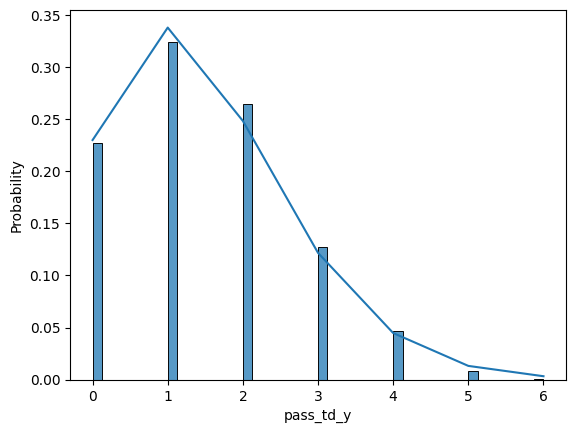

In [8]:
# We want to see if a Poisson distribution is reasonable for this analysis.
# We will look at a bar graph of frequencies and compare to a Poisson distribution
  # of the same mean
pass_td_y_mean_py =\
  pbp_py_pass_td_y\
  .pass_td_y\
  .mean()

plot_pos_py =\
  pd.DataFrame(
      {'x': range(0, 7),
       'expected': [poisson.pmf(x, pass_td_y_mean_py) for x in range(0, 7)]
       }
  )

sns.histplot(pbp_py_pass_td_y['pass_td_y'], stat='probability');
plt.plot(plot_pos_py.x, plot_pos_py.expected);
plt.show();

In [9]:
# We want to determine the total for each game
# This will take into account: defensive strength, pace, and weather.
# The total will be our 'x' in our model.
# We start w/ players w/ >= 10 passes.
pbp_py_pass_td_y_geq10 =\
  pbp_py_pass_td_y.query('n_passes >= 10')

# Take the avg TD passes for each QB for the previous season.
# Add current season up to the current game.
x_py = pd.DataFrame()
for season_idx in range(2017, 2022+1):
  for week_idx in range(1, 22+1):
    week_calc_py = (
        pbp_py_pass_td_y_geq10\
          .query('(season == ' +
                 str(season_idx - 1) +
                 ') |' +
                 '(season == ' +
                 str(season_idx) +
                 '&' +
                 'week < ' +
                 str(week_idx) +
                 ')')\
        .groupby(['passer_id', 'passer'])\
        .agg({'pass_td_y': ['count', 'mean']})
    )
    week_calc_py.columns =\
      list(map('_'.join, week_calc_py.columns))
    week_calc_py.reset_index(inplace=True)
    week_calc_py\
      .rename(columns={
          'pass_td_y_count': 'n_games',
          'pass_td_y_mean': 'pass_td_rate'},
      inplace=True)
    week_calc_py['season'] = season_idx
    week_calc_py['week'] = week_idx
    x_py = pd.concat([x_py, week_calc_py])

In [10]:
# Let's look at Mahomes going into SB LVII
x_py.query('passer == "P.Mahomes"').tail()

,passer_id,passer,n_games,pass_td_rate,season,week
39,00-0033873,P.Mahomes,36,2.444444,2022,18
40,00-0033873,P.Mahomes,37,2.405406,2022,19
40,00-0033873,P.Mahomes,37,2.405406,2022,20
40,00-0033873,P.Mahomes,38,2.394737,2022,21
40,00-0033873,P.Mahomes,39,2.384615,2022,22


In [11]:
# Now we can merge our datasets together.
pbp_py_pass_td_y_geq10 =\
  pbp_py_pass_td_y_geq10.query('season != 2016')\
  .merge(x_py,
         on=['season', 'week', 'passer_id', 'passer'],
         how='inner')


In [12]:
# We can now make our Poisson distribution to model the number of TD passes thrown in a game.
# We will code the model, save the outputs in column exp_pass_td and then look at the summary.
pass_fit_py =\
  smf.glm(
      formula='pass_td_y ~ pass_td_rate + total_line',
      data=pbp_py_pass_td_y_geq10,
      family=sm.families.Poisson())\
    .fit()

pbp_py_pass_td_y_geq10['exp_pass_td'] = \
  pass_fit_py\
  .predict()

print(pass_fit_py.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              pass_td_y   No. Observations:                 3297
Model:                            GLM   Df Residuals:                     3294
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4873.8
Date:                Mon, 08 Jan 2024   Deviance:                       3395.2
Time:                        21:46:24   Pearson chi2:                 2.83e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07146
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9851      0.148     -6.641   

In [13]:
# For a Poisson regression, our coefficients are on the exponential scale.
# We will access the model's parameters and then take the exponential.
np.exp(pass_fit_py.params)

Intercept       0.373411
pass_td_rate    1.358860
total_line      1.019791
dtype: float64

In [14]:
# Let's look at Mahomes' data from SB LVII
# We will start with our filter criteria.
filter_by = 'passer == "P.Mahomes" & season == 2022 & week == 22'
# Specifiy columns next.
cols_look = [
    'season',
    'week',
    'passer',
    'total_line',
    'n_games',
    'pass_td_rate',
    'exp_pass_td',
]

pbp_py_pass_td_y_geq10.query(filter_by)[cols_look]

,season,week,passer,total_line,n_games,pass_td_rate,exp_pass_td
3295,2022,22,P.Mahomes,51.0,39,2.384615,2.107833


In [15]:
# n_games shows that there are a total of 39 games (21 from the 2022 season and 18
  # from the previous season) in the Mahomes sample that we are considering.
# pass_td_rate is the current average number of touchdown passes per game by
  # Mahomes in the sample that we are considering.
# exp_pass_td is the expected number of touchdown passes from the model for
  # Mahomes in the Super Bowl.

In [16]:
# We will use a poisson PMF to determine the probability of more than two TD passes by a QB.
pbp_py_pass_td_y_geq10['p_0_td'] = \
  poisson.pmf(k=0,
              mu=pbp_py_pass_td_y_geq10['exp_pass_td'])

pbp_py_pass_td_y_geq10['p_1_td'] = \
  poisson.pmf(k=1,
              mu=pbp_py_pass_td_y_geq10['exp_pass_td'])

pbp_py_pass_td_y_geq10['p_2_td'] = \
  poisson.pmf(k=2,
              mu=pbp_py_pass_td_y_geq10['exp_pass_td'])

pbp_py_pass_td_y_geq10['p_g2_td'] = \
  1 - poisson.cdf(k=2,
                  mu=pbp_py_pass_td_y_geq10['exp_pass_td'])

In [17]:
# We can look at the outputs for Mahomes going into the SB.
# Specify filter criteria on own line for space.
filter_by = 'passer == "P.Mahomes" & season == 2022 & week == 22'

# Specify columns on own line for space.
cols_look = [
    'passer',
    'total_line',
    'n_games',
    'pass_td_rate',
    'exp_pass_td',
    'p_0_td',
    'p_1_td',
    'p_2_td',
    'p_g2_td',
]

pbp_py_pass_td_y_geq10\
  .query(filter_by)[cols_look]

,passer,total_line,n_games,pass_td_rate,exp_pass_td,p_0_td,p_1_td,p_2_td,p_g2_td
3295,P.Mahomes,51.0,39,2.384615,2.107833,0.121501,0.256104,0.269912,0.352483
